is in ipython: 1
[WARN] pymisca.vis_util cannot find network


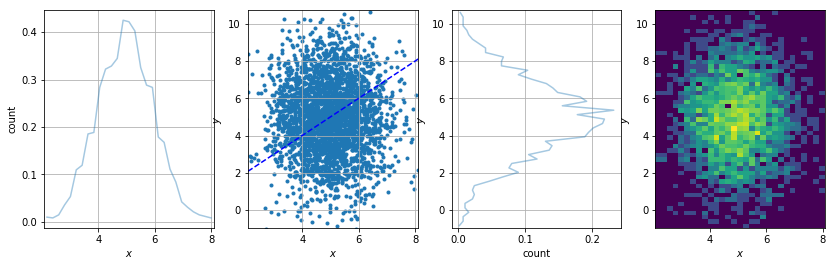

In [15]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
%matplotlib inline 


D = 2


TRUE_MU = 0.0
TRUE_SIGMA = 2.0
SAMPLE_SIZE = (5000,D)

np.random.seed(0)
x_obs = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=SAMPLE_SIZE)
rsq = np.square(x_obs).sum(axis=-1)

##### Make a Ring
# keep = rsq > np.mean(rsq)
# x_obs = x_obs[keep]

#### Random Linear transformation
# C = pyutil.random_covmat()
# x_obs = x_obs.dot(C)

#### Make an ellipse
x_obs.T[0] *= 0.5

### Shift
x_obs = x_obs + (5.,5.)

X = x_obs.astype(np.float32)

# x_obs = np.square(x_obs)
pyvis.qc_2var(x_obs.T[0],x_obs.T[1])

In [2]:

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
import pymisca.tensorflow_extra as pytf;reload(pytf)
import tensorflow_probability as tfp
import tensorflow as tf
tfdist = tfp.distributions

%matplotlib inline 

is in ipython: 1
[WARN] pymisca.vis_util cannot find network


/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[WARN]unable to import edward.models
[WARN]unable to import edward.models


/home/shouldsee/.local/lib/python2.7/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


\int P(	heta) P(r^2) \partial x \partial y
0.9942753314971924


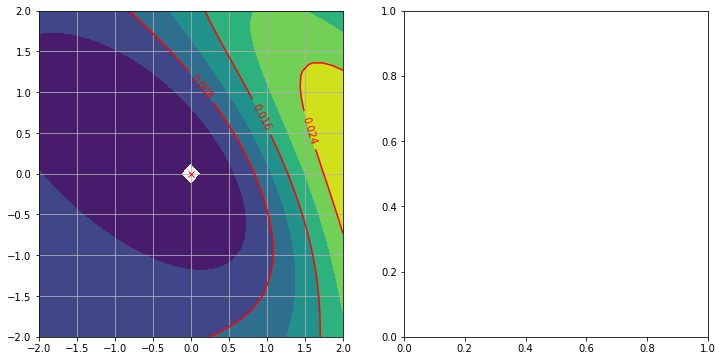

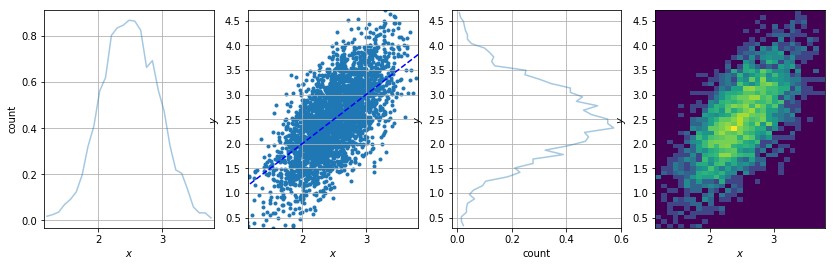

In [16]:
def makeEMD( (mu,phi,sigma,kappa) ):
    dist_rsq   = tfdist.Gamma(mu,phi)
#     dist_rsq = tfbij.Invert(tfbij.Square()) (dist_r)

    
    dist_Theta = pytf.VonMisesFisherCosine(D=2,
                                           concentration = 1.)

    dist_rsqTheta = mdl=  pytf.JointScalar(
        [
            tfdist.Gamma(mu,phi,name='r_squared'),
            dist_Theta,
        ])

    #### Use a bijector to calculate P(x) from P(r^2)
    dist_xyz = mdl = pytf.AsRadialCosine(distribution=mdl,D=D)
    
    ### Allow an affine transformation y = M x + x_0
    dist_aff = mdl = pytf.AffineTransformDiagPlusLowRank(
        distribution=dist_xyz,
        loc = tf.zeros(D),
        scale_diag= tf.ones(D)*sigma,
        scale_perturb_factor = kappa,
        
    )
    # gaussian_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
    # emission  = dist_rsq
    return mdl
# print em.distribution.event_shape
ptb = np.reshape([-1.,1.],[2,1]).astype('float32')
em = makeEMD((2., 1.,2.,ptb))
sess = tf.InteractiveSession()
f = em.prob
f = pyutil.wrapTFmethod(f)
f = pyutil.arrayFunc2mgridFunc(f)

with sess.as_default():
    pyvis.dmet_2d(f,vectorised=1);
    iY = em.bijector.inverse(X).eval()
    pyvis.qc_2var(iY.T[0],iY.T[1])
    pyutil.printlines(
        ('\int P(\theta) P(r^2) \partial x \partial y',
           pyutil.cubicRInt(f.arrayFunc,D=D,N=2000000,R=16.))
    )





In [17]:
RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)
INIT_MU_PARAMS = {'loc':0.,'scale':1.}
mu = 0. + tf.nn.softplus(tf.Variable(
    initial_value=np.random.normal(**INIT_MU_PARAMS),
                 dtype=tf.float32)
                )
phi =tf.nn.softplus( tf.Variable(
    initial_value=np.random.normal(**INIT_MU_PARAMS),
                  dtype=tf.float32)
                )
sigma =tf.nn.softplus( tf.Variable(
    initial_value=np.random.normal(**INIT_MU_PARAMS),
                  dtype=tf.float32)
                )
kappa = tf.Variable(
    initial_value=np.random.normal(size=(D,1),**INIT_MU_PARAMS),
                  dtype=tf.float32)

x = tf.placeholder(dtype='float32')
fitted_vars = [mu,phi,sigma,kappa]


EMD = makeEMD(fitted_vars)
neg_log_likelihood = -tf.reduce_sum(EMD.log_prob(x))
# neg_log_likelihood = 
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/
reload(pytf)
LEARNING_RATE = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
sess,last_vars, hist_loss, opt = pytf.op_minimise(
    neg_log_likelihood,
    fitted_vars,
    optimizer,
    feed_dict = {x: x_obs}
)

[WARN]unable to import edward.models
Iter 0 133950.53
Iter 100 22441.492
Iter 200 22039.365
Iter 300 21900.236
Iter 400 21850.365
Iter 500 21832.664
Iter 600 21826.602
Loss function convergence in 687 iterations!: 21824.8164062


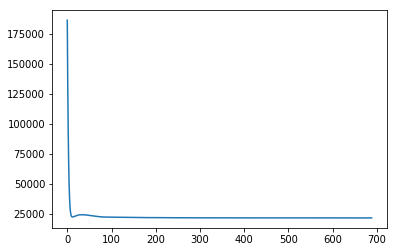

In [18]:
import pymisca.vis_util as pyvis
%matplotlib inline 

plt = pyvis.plt
plt.plot(hist_loss)

In [19]:
print (last_vars)

[6.2920675, 0.7985841, 1.1395123, array([[-0.8274125],
       [-1.1038613]], dtype=float32)]


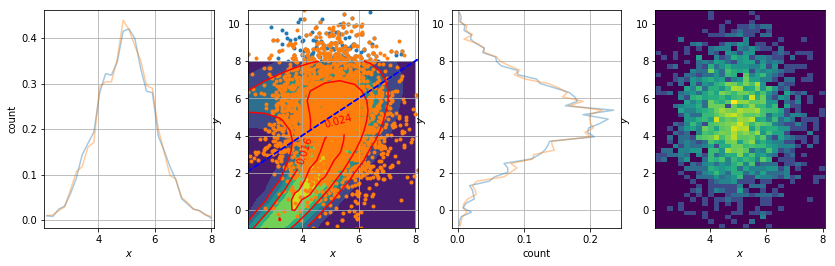

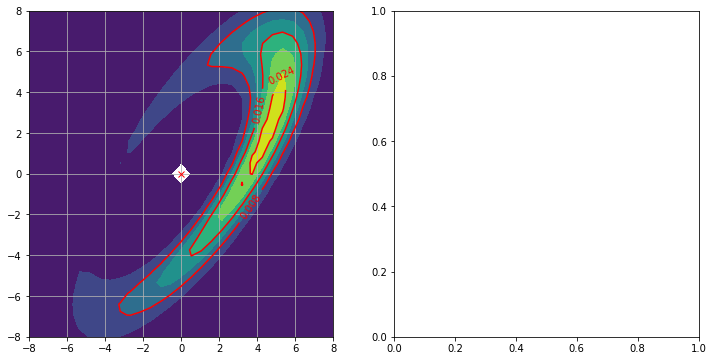

In [20]:
with sess.as_default():
# sess = tf.InteractiveSession()
# if 1:
    EMD = makeEMD(last_vars)
    X = x_obs
    axs = pyvis.qc_2var(X.T[0],X.T[1])
    
    f = EMD.prob
    f = pyutil.wrapTFmethod(f)
    f = pyutil.arrayFunc2mgridFunc(f)
    pyvis.dmet_2d(f,vectorised=1,span=[-8,8],ax=axs[1]);    
    pyvis.qc_2var(X.T[0],X.T[1],axs=axs)
#     Y = EMD.sample(len(X)).eval()
    pyvis.dmet_2d(f,vectorised=1,span=[-8,8],);    

#     pyvis.qc_2var(Y.T[0],Y.T[1])

In [23]:
from tensorflow.python.framework import tensor_util
from tensorflow.python.framework import ops
def _static_value(x):
  """Returns the static value of a `Tensor` or `None`."""
  return tensor_util.constant_value(ops.convert_to_tensor(x))

In [25]:
print _static_value(x)

None
